In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings



---



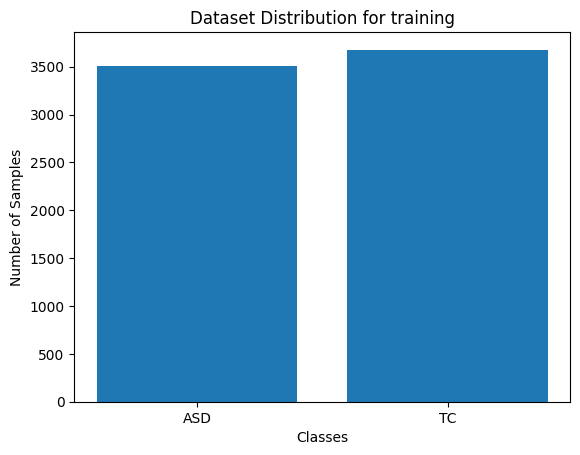

In [7]:
data_dir = '/content/drive/MyDrive/ABIDE-I dataset/A_Prepared_Data/train'
classes = ['ASD', 'TC']

class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

# Plot the dataset distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Dataset Distribution for training')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.show()


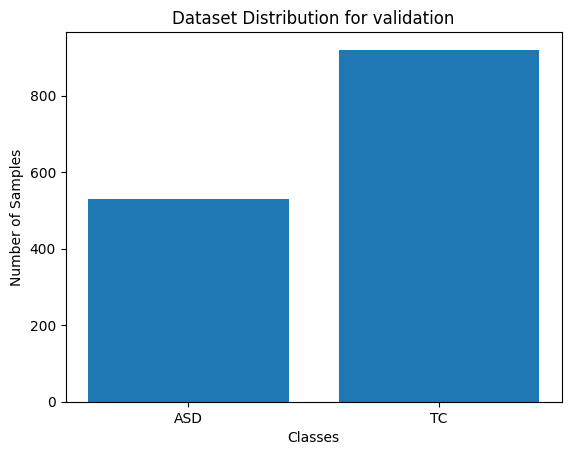

In [8]:
data_dir = '/content/drive/MyDrive/ABIDE-I dataset/A_Prepared_Data/validate'
classes = ['ASD', 'TC']

class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

# Plot the dataset distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Dataset Distribution for validation')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.show()


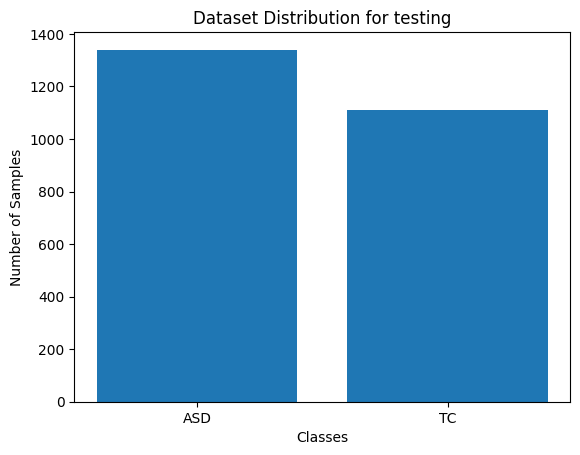

In [9]:
data_dir = '/content/drive/MyDrive/ABIDE-I dataset/A_Prepared_Data/test'
classes = ['ASD', 'TC']

class_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

# Plot the dataset distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Dataset Distribution for testing')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.show()


Applying **Data Augmentation** on the dataset

In [3]:
# Part 1 - Getting the data and defining parameters

from keras.preprocessing.image import ImageDataGenerator
input_size = (224, 224)

train_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)
training_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/ABIDE-I dataset/A_Prepared_Data/train',
                                                 target_size = input_size,
                                                 class_mode = 'binary',
                                                  classes=['ASD', 'TC']
                                                 )

# validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/ABIDE-I dataset/A_Prepared_Data/validate',
                                                 target_size = input_size,
                                                 class_mode = 'binary',
                                                   classes=['ASD', 'TC']
                                                 )

# test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/ABIDE-I dataset/A_Prepared_Data/test',
                                            target_size = input_size,
                                            class_mode = 'binary',
                                            classes=['ASD', 'TC']
                                            )

Found 7186 images belonging to 2 classes.
Found 1450 images belonging to 2 classes.
Found 2450 images belonging to 2 classes.


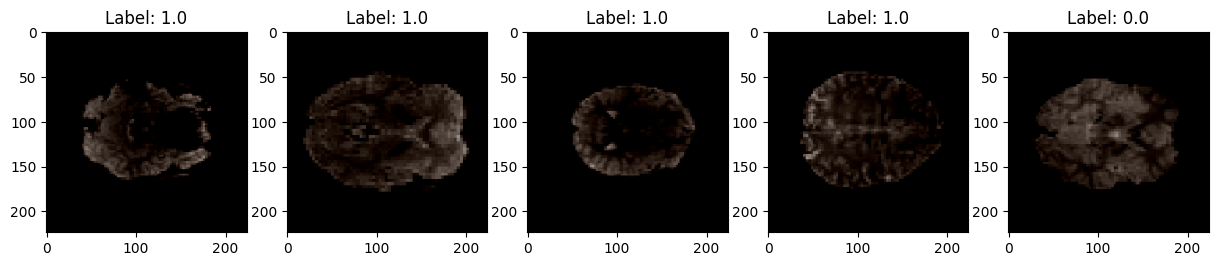

'\nprint(label, image.min(), image.max())\n\n0.0 -0.48501962 0.59239614\n0.0 -0.48501962 0.59239614\n1.0 -0.48501962 0.59239614\n1.0 -0.48501962 0.59239614\n1.0 -0.48501962 0.59239614\n'

In [20]:
num_images_to_plot = 5
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 3))

for i in range(num_images_to_plot):
    # Get a batch of augmented images
    batch = training_set.next()

    # Extract the first image and label from the batch
    image = batch[0][0]
    label = batch[1][0]



    # Display the image and label
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')

plt.show()

"""
print(label, image.min(), image.max())

0.0 -0.48501962 0.59239614
0.0 -0.48501962 0.59239614
1.0 -0.48501962 0.59239614
1.0 -0.48501962 0.59239614
1.0 -0.48501962 0.59239614
"""

In [ ]:
image_names = training_set.filenames
labels = training_set.labels

for i in range(len(image_names)):
    print(f"Image Name: {image_names[i]}, Label: {labels[i]}")

# Image Name: ASD/slice0050815_025.png, Label: 0
# Image Name: TC/slice0050040_015.png, Label: 1

# Transfer Learning

In [4]:
input_size += (3, )

resnet = ResNet50(weights='imagenet',include_top=False,input_shape=input_size)

94765736/94765736 [==============================] - 0s 0us/step


In [5]:
for layer in resnet.layers:
    layer.trainable = False

model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.2)(model)
model = tf.keras.layers.Dense(128,activation='relu')(model)
model = tf.keras.layers.Dropout(rate=0.2)(model)
model = tf.keras.layers.Dense(64,activation='relu')(model)
model = tf.keras.layers.Dense(1,activation='sigmoid')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [16]:
base_learning_rate = 0.001
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate),
              metrics= ['accuracy'])

In [8]:
# tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/ABIDE-I dataset/resnet50",monitor="val_accuracy",save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 2, min_delta = 0.001,verbose=1)

---

# Training The Model

In [9]:
initial_epochs = 5

history = model.fit(
    training_set,
    # steps_per_epoch=training_set.n // 32,
    validation_data=validation_set,
    # validation_steps = validation_set.n // 32,
    epochs=initial_epochs, verbose=1, batch_size=32,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/5
225/225 [==============================] - ETA: 0s - loss: 0.7085 - accuracy: 0.5007
Epoch 1: val_accuracy improved from -inf to 0.63448, saving model to /content/drive/MyDrive/ABIDE-I dataset/resnet50
225/225 [==============================] - 1978s 9s/step - loss: 0.7085 - accuracy: 0.5007 - val_loss: 0.6899 - val_accuracy: 0.6345 - lr: 0.0010
Epoch 2/5
225/225 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.5053
Epoch 2: val_accuracy did not improve from 0.63448
225/225 [==============================] - 41s 181ms/step - loss: 0.6957 - accuracy: 0.5053 - val_loss: 0.6885 - val_accuracy: 0.6345 - lr: 0.0010
Epoch 3/5
225/225 [==============================] - ETA: 0s - loss: 0.6961 - accuracy: 0.4936
Epoch 3: val_accuracy did not improve from 0.63448

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
225/225 [==============================] - 37s 166ms/step - loss: 0.6961 - accuracy: 0.4936 - val_loss: 0.6818 - val_accuracy

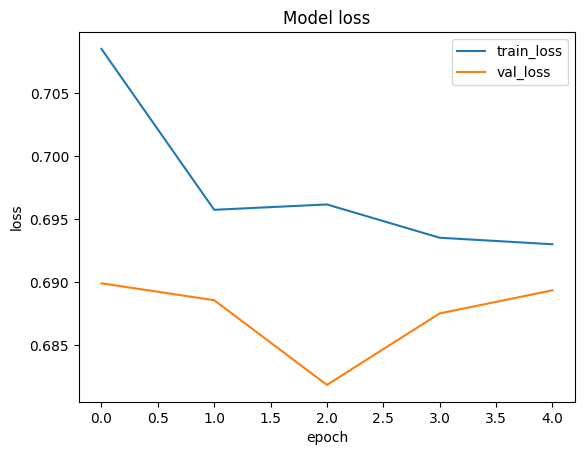

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

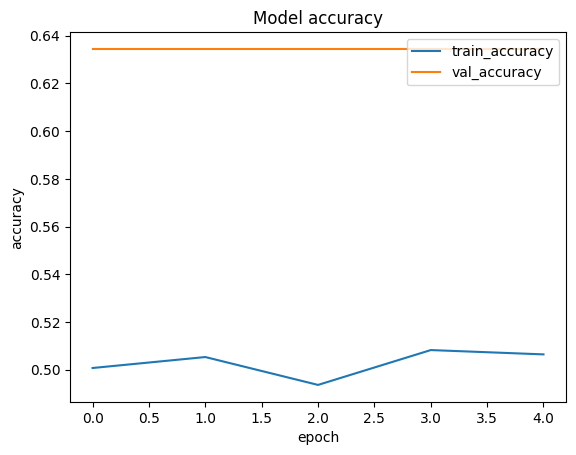

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'upper right')
plt.show()

# Prediction

In [12]:
from sklearn.metrics import accuracy_score, roc_curve, auc

77/77 [==============================] - 911s 12s/step
Test Accuracy: 45.31%


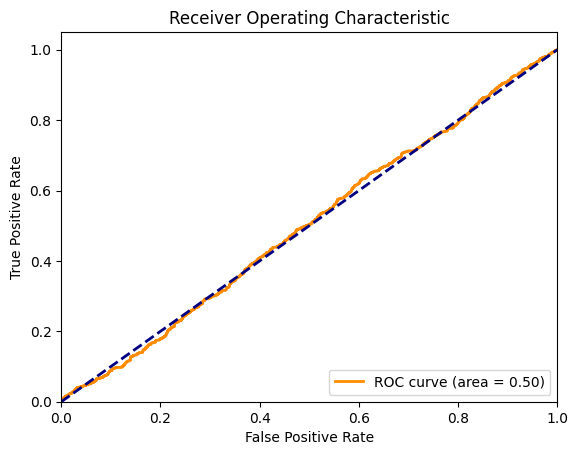

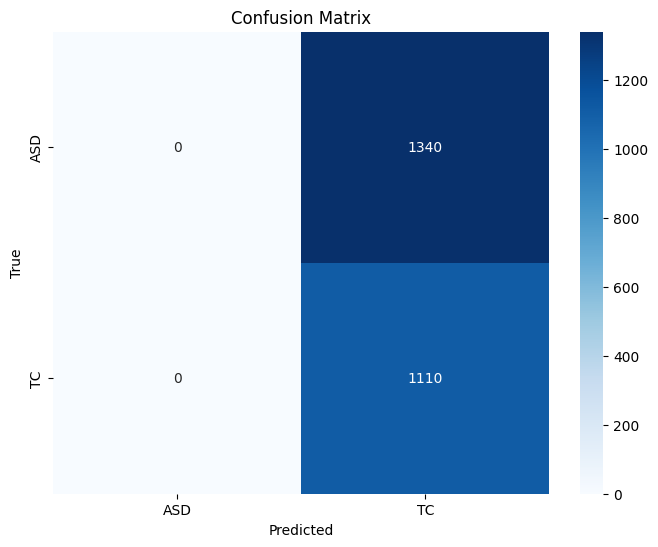

Confusion Matrix:
[[   0 1340]
 [   0 1110]]


In [13]:
class_names = list(training_set.class_indices.keys())

# Make predictions on the test data
predictions = model.predict(test_set)

# 'predictions' will contain the predicted probabilities for each image
# For binary classification, you can threshold the probabilities to get class predictions (0 or 1)
predicted_classes = (predictions > 0.5).astype(int)

# Get the true class labels for the test data
true_classes = test_set.classes

# Calculate test accuracy
test_accuracy = accuracy_score(true_classes, predicted_classes)

# Print and return the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print and return the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

In [14]:
model.load_weights("/content/drive/MyDrive/ABIDE-I dataset/resnet50")

In [15]:
evaluate = model.evaluate(test_set, steps = test_set.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

76/76 [==============================] - 9s 121ms/step - loss: 0.6945 - accuracy: 0.4544
Accuracy Test : 0.4543585479259491


# Fine Tuning

In [17]:
split_at = 140
for layer in model.layers[:split_at]: layer.trainable = False
for layer in model.layers[split_at:]: layer.trainable = True

In [ ]:
base_learning_rate = 0.001
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate*0.1),
              metrics= ['accuracy'])

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [20]:
# tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/ABIDE-I dataset/resnet502",monitor="val_accuracy",save_best_only=True,verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 2, min_delta = 0.001,verbose=1)

In [21]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(training_set,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_set,
                         verbose=1, batch_size=32,
                         callbacks=[checkpoint])

Epoch 5/10
225/225 [==============================] - ETA: 0s - loss: 0.6988 - accuracy: 0.4968
Epoch 5: val_accuracy improved from -inf to 0.63448, saving model to /content/drive/MyDrive/ABIDE-I dataset/resnet502
225/225 [==============================] - 76s 283ms/step - loss: 0.6988 - accuracy: 0.4968 - val_loss: 0.6771 - val_accuracy: 0.6345
Epoch 6/10
225/225 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.5090
Epoch 6: val_accuracy did not improve from 0.63448
225/225 [==============================] - 40s 177ms/step - loss: 0.6933 - accuracy: 0.5090 - val_loss: 0.6901 - val_accuracy: 0.6345
Epoch 7/10
225/225 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5121
Epoch 7: val_accuracy did not improve from 0.63448
225/225 [==============================] - 47s 209ms/step - loss: 0.6930 - accuracy: 0.5121 - val_loss: 0.6874 - val_accuracy: 0.6345
Epoch 8/10
225/225 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0

# Evaluation after fine tuning

In [22]:
model.load_weights("/content/drive/MyDrive/ABIDE-I dataset/resnet502")

evaluate = model.evaluate(test_set, steps = test_set.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

76/76 [==============================] - 11s 135ms/step - loss: 0.7021 - accuracy: 0.4523
Accuracy Test : 0.45230263471603394
